In [2]:
import os
import xarray as xr
import time
import pandas as pd
import numpy as np
from google.cloud import storage
import netCDF4
import zarr
import numcodecs
import gcsfs
import dask
import dask.array

## Read NetCDF from GCP

In [3]:
client = storage.Client()

In [4]:
BUCKET = 'solar-pv-nowcasting-data'
SATELLITE_DATA_PATH = 'satellite/EUMETSAT/SEVIRI_RSS/reprojected/just_UK/2019/06/03/'
ZARR_PATH = BUCKET + '/benchmarking/zarr'

In [5]:
blobs = client.list_blobs(BUCKET, prefix=SATELLITE_DATA_PATH)
blobs = list(blobs)
print(f'{len(blobs)} netcdf files found.')

18 netcdf files found.


In [6]:
def open_netcdf_from_gcp(blob):
    # Adapted from https://github.com/pydata/xarray/issues/1075#issuecomment-373541528
    netcdf_bytes = blob.download_as_bytes()
    nc4_ds = netCDF4.Dataset('EUMETSAT', memory=netcdf_bytes)
    store = xr.backends.NetCDF4DataStore(nc4_ds)
    return xr.open_dataset(store, engine='netcdf4')

In [7]:
%%time

concat_da = []
for blob in blobs:
    da = open_netcdf_from_gcp(blob)['HRV']
    concat_da.append(da)
    
concat_da = xr.concat(concat_da, dim='time')

CPU times: user 9.09 s, sys: 1.58 s, total: 10.7 s
Wall time: 14 s


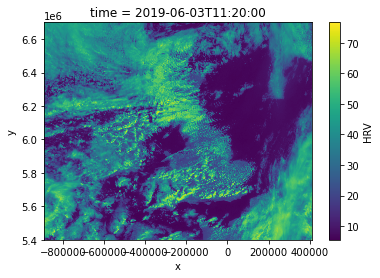

In [8]:
concat_da.isel(time=100).plot()

## Save to GCP as Zarr

In [9]:
def change_bits_per_pixel(da: xr.DataArray, bits_per_pixel: int) -> xr.DataArray:
    da = da.copy(deep=True)
    da -= da.min()
    da /= da.max()
    upper_bound = (2 ** bits_per_pixel) - 1
    da *= upper_bound
    da = da.round()
    assert da.min() == 0
    assert da.max() == upper_bound
    return da


def save_to_zarr(da: xr.DataArray, store, compressor=None, filters=None, chunks=None):
    DA_NAME = 'HRV'
    ds = xr.Dataset({DA_NAME: da})
    encoding = {DA_NAME: {'compressor': compressor, 'filters': filters}}
    if chunks is not None:
        encoding[DA_NAME]['chunks'] = chunks
    ds.to_zarr(store, mode='w', encoding=encoding)

In [10]:
concat_da.shape

(216, 1300, 1301)

In [11]:
gcs = gcsfs.GCSFileSystem()
store = gcsfs.GCSMap(root=ZARR_PATH, gcs=gcs)

In [39]:
%%time
def save():
    da = change_bits_per_pixel(concat_da, bits_per_pixel=12)
    da = da.astype(np.uint16)
    save_to_zarr(
        da, store, 
        compressor=numcodecs.Blosc(cname="zstd", clevel=5),
        chunks=(64, 256, 256)  # default = (27, 163, 163)
    )

save()

CPU times: user 39.1 s, sys: 1.25 s, total: 40.4 s
Wall time: 35.4 s


In [40]:
%%time
zarr.consolidate_metadata(store)

CPU times: user 23.7 ms, sys: 5.11 ms, total: 28.8 ms
Wall time: 611 ms


<zarr.hierarchy.Group '/'>

In [41]:
%%time
du_mb_total = gcs.du(ZARR_PATH) / 1E6

CPU times: user 114 ms, sys: 5.28 ms, total: 119 ms
Wall time: 1.6 s


In [42]:
print(f'{du_mb_total:,.1f} MBytes')

385.4 MBytes


In [43]:
du_mb_per_chunk = gcs.du(ZARR_PATH + '/HRV/0.0.0') / 1E6
print(f'{du_mb_per_chunk:,.1f} MB per chunk')

8.6 MB per chunk


## Read from GCP (single process; single thread)

In [44]:
def load_all(ds):
    ds.load()
    

def load_rectangle(ds):
    ds_rect = ds['HRV'][:, 128:256, 128:256]
    ds_rect.load()

In [45]:
NUM_RUNS = 3
col_to_func = {'all': load_all, 'rectangle': load_rectangle}
runtimes = pd.DataFrame(np.NaN, columns=col_to_func.keys(), index=range(NUM_RUNS))

for run_i in range(NUM_RUNS):
    print(run_i)
    for col, func in col_to_func.items():
        print(col, end=': ')
        read_ds = xr.open_zarr(store, consolidated=True)
        t0 = time.time()
        func(read_ds)
        t1 = time.time()
        runtime = t1 - t0
        print(f'{runtime:.1f} seconds')
        runtimes[col][run_i] = runtime

0
all: 2.8 seconds
rectangle: 0.2 seconds
1
all: 2.6 seconds
rectangle: 0.2 seconds
2
all: 2.6 seconds
rectangle: 0.1 seconds


In [46]:
runtimes

,all,rectangle
0,2.816817,0.245958
1,2.621037,0.158841
2,2.593035,0.106154


In [47]:
runtimes.mean()

all          2.676963
rectangle    0.170318
dtype: float64

In [48]:
# _ = zarr.blosc.set_nthreads(4)
zarr.blosc.get_nthreads()

4

## Read from GCP (using dask)

In [49]:
zarr_store = zarr.open_consolidated(store)

In [50]:
zarr_array = zarr_store['HRV']

In [51]:
zarr_array.chunks

(128, 256, 256)

In [52]:
%%time
dask_zarr = dask.array.from_zarr(zarr_array)

CPU times: user 630 µs, sys: 0 ns, total: 630 µs
Wall time: 578 µs


In [53]:
dask_zarr

dask.array<from-zarr, shape=(216, 1300, 1301), dtype=uint16, chunksize=(128, 256, 256), chunktype=numpy.ndarray>

In [60]:
dask_slice = dask_zarr[:, 128:256, 128:256]

In [63]:
# dask_slice.visualize(filename='dask_graph.svg')

In [72]:
%%time
dask_slice_materialised = dask_slice.compute() # scheduler='single-threaded') # (scheduler='threads')

CPU times: user 97.4 ms, sys: 4.11 ms, total: 101 ms
Wall time: 159 ms
